<img src="../../../docs/images/DSPy8.png" alt="DSPy7 Image" height="150"/>

# Using __<ins>M</ins>ulti-stage <ins>I</ins>nstruction <ins>P</ins>roposal & <ins>O</ins>ptimization (MIPROv2)__ in DSPy
[![colab-badge](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/stanfordnlp/dspy/blob/main/examples/qa/hotpot/hotpotqa_with_MIPRO.ipynb)

### FAQ 🙋
#### 1) How does MIPRO work?
At a high level, the MIPRO program optimizer works by first __proposing__ candidate fewshot example sets and instructions for each prompt in your program, and then __optimizing__ over these fewshot example sets and instructions as hyperparameters for a specified number of trials. Each trial, the optimizer evaluates different combinations of prompts on a train set, which allows it to learn which combinations yield the best performance.

#### 2) How much will MIPRO cost me to run?
Note that __this notebook__ is free to run, because all LM calls have been cached. However, when using an optimizer on your own program, here is a breakdown of the upper bound of the number of calls to the task model and prompt model respectively:

- **Task model calls**: MIPRO makes up to __O(TxPxM)__ task model calls if you run without minibatching, where T is the number of trials, P is the number of prompts in the program, and M is the size of the train set. This is because the model is evaluating the program on the train set each trial. In practice, this should be lower given that MIPRO tunes poor trials early (ie. it may stop a trial after running on the first 100 or so examples if performance is poor).  If you run **with minibatching** you can reduce calls even further to __O(TxPxB)__ where **B** is the minibatch size.  Note that every few steps (a parameter you set) MIPRO will also run a full eval over all **M** examples.

- **Prompt model calls**: MIPRO makes up to N*P+10+(P+1) prompt model calls, where N is the number of instruction / fewshot example set candidates to generate for each prompt, and P is the number of prompts in the program. The extra 10 calls comes from generating a summary of the data in the training set, which we use in the meta prompt to create better instructions.  The extra (P+1) comes from program summarization where the proposer LLM will look at the program code and try to describe what each module does and what the whole program does.

#### 3) How should I configure the hyperparameters?
We have yet to run full hyperparameter sweeps with MIPRO, but based off of initial experimintation, we'd recommend the following:
- __Trial num__: Gains can be seen after about 20-30 trials. However, 100-200 trials can help with adding on additional marginal gains.
- __num candidates__: This hyperparameter controls the number of candidate prompts and fewshot example sets that are generated to optimize over. With more trials and less prompts to optimize, we can set n to be higher, as we have more trials to explore different combinations of prompts. If your program has between 2-3 modules and is the `num_trials=30`, we'd recommend ~`n=10`. If n is higher (say `n=100`), then we can go higher to ~`n=15`. If you have a program with only 1 module and are keeping the program 0-shot (ie. no fewshot examples), then `num_trials` should be set to equal `n`, because each trial can explore a new instruction.
- __Training set size__: Between 200 and 500 training examples are recommended. Increasing the training set size can help prevent overfitting, but adds to the expense to run.

#### 4) What should I do if I want to reduce the cost?
You can always update hyperparameters accordingly, such as using a smaller train set, using less trials, or using a program with less modules.  You should take advantage of minibatching.
Alternatively, one strategy would be to optimize using a cheaper task model (ie. locally hosted Llama-3), as initial experiments have shown that prompts optimized for a smaller model also transfer to working well on a larger model.


### 0] Setup

First, we will install __DSPy__ if it's not there already. We'll also __load in the cached requests__ for this tasks, so that we don't actually need to call any LMs for this notebook. We'll also load in our pre optimized program from hugging face to inspect later.

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os

try: # When on google Colab, let's clone the notebook so we download the cache.
    import google.colab
    repo_path = 'dspy'

    !git -C $repo_path pull origin || git clone https://github.com/stanfordnlp/dspy $repo_path
except:
    repo_path = '.'

if repo_path not in sys.path:
    sys.path.append(repo_path)


import pkg_resources # Install the package if it's not installed
if not "dspy-ai" in {pkg.key for pkg in pkg_resources.working_set}:
    !pip install -U pip
    !pip install dspy-ai
    !pip install openai~=0.28.1
    !pip install -e $repo_path
    !pip install --upgrade cloudpickle==3.0.0

from huggingface_hub import hf_hub_download
import zipfile
import os

repo_id = 'MichaelR207/MIPRO_notebook_cache_scone'
cache_file_path = hf_hub_download(repo_id=repo_id, repo_type='dataset', filename='MIPRO_notebook_cache.zip')
compiled_program_file_path = hf_hub_download(repo_id=repo_id, repo_type='dataset', filename='compiled_program.dspy')
trial_logs_file_path = hf_hub_download(repo_id=repo_id, repo_type='dataset', filename='trial_logs.pickle')

with zipfile.ZipFile(cache_file_path, 'r') as zip_ref:
    zip_ref.extractall(".")

import dspy
import pandas as pd
import glob
import random
from dspy.evaluate import Evaluate

/opt/miniconda3/envs/opt-prompt/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We will also specify the __prompt LM model__ (in this case GPT 3.5), the __task LM model__ (Llama 3 8B)

In [2]:
import openai

### NOTE: if you'd like to run this code without a cache, you can remove these lines to configure your OPEN AI key ###
# os.environ['OPENAI_API_KEY'] = "TODO: ADD YOUR OPEN AI KEY HERE"
# openai.api_key = os.environ.get('OPENAI_API_KEY')
# openai.api_base = "https://api.openai.com/v1"

prompt_model_name = "gpt-3.5-turbo-1106"
task_model_name = "meta-llama/Meta-Llama-3-8B"

prompt_model = dspy.OpenAI(model=prompt_model_name, max_tokens=1000, stop=["\n\n", "\n---"])
task_model = dspy.HFClientVLLM(
    model=task_model_name,
    port=7410,
    url=["http://future-hgx-2:7500", "http://future-hgx-2:7501", "http://future-hgx-2:7502", "http://future-hgx-2:7503", "http://future-hgx-2:7504", "http://future-hgx-2:7505", "http://future-hgx-2:7506", "http://future-hgx-2:7507"],
    max_tokens=1000,
    stop=["\n\n", "\n---", "assistant"],
)

dspy.settings.configure(lm=task_model)

### 1] Define Task

Here, we'll define the program that we'd like to run, which is a multihop [...] (we can say that it was loosely inspired by a certain paper). We additionally load in the data, and define how we'd like to evaluate this task.

In [3]:
!git clone https://github.com/selenashe/ScoNe.git

fatal: destination path 'ScoNe' already exists and is not an empty directory.


In [4]:
class ScoNeSignature(dspy.Signature):
    ("""context, question -> answer""")

    context = dspy.InputField()
    question = dspy.InputField()
    answer = dspy.OutputField(desc="Yes or No")

class ScoNeCoT(dspy.Module):
    def __init__(self):
        super().__init__()
        self.generate_answer = dspy.ChainOfThought(ScoNeSignature)

    def forward(self, context, question):
        return self.generate_answer(context=context, question=question)

In [5]:
def load_scone(dirname):
    dfs = []
    for filename in glob.glob(dirname + "/*.csv"):
        df = pd.read_csv(filename, index_col=0)
        df['category'] = os.path.basename(filename).replace(".csv", "")
        dfs.append(df)
    data_df = pd.concat(dfs)

    def as_example(row):
        # The 'one_scoped' file is from an earlier dataset, MoNLI, and
        # so is formatted a bit differently:
        suffix = '' if row['category'] == 'one_scoped' else '_edited'
        # Reformat the hypothesis to be an embedded clause in a question:
        hkey = 'sentence2' + suffix
        question = row[hkey][0].lower() + row[hkey][1: ].strip(".")
        question = f"Can we logically conclude for sure that {question}?"
        # Binary task formulation:
        label = "Yes" if row['gold_label' + suffix] == 'entailment' else "No"
        return dspy.Example({
            "context": row['sentence1' + suffix],
            "question": question,
            "answer": label,
            "category": row['category'],
        }).with_inputs("context", "question")
    return list(data_df.apply(as_example, axis=1).values)

In [6]:
# Load and configure the datasets.
all_train = load_scone("ScoNe/scone_nli/train")

random.seed(1)
random.shuffle(all_train)

# 1000 random train, 500 random dev:
trainset, valset, testset = all_train[: 200], all_train[200: 400], all_train[400: 600]

In [7]:
# Set up metrics
NUM_THREADS = 10
metric = dspy.evaluate.answer_exact_match

kwargs = dict(num_threads=NUM_THREADS, display_progress=True)
evaluate = Evaluate(devset=valset, metric=metric, **kwargs)

program = ScoNeCoT()

### 2] Baseline Evaluation
Now, we'll quickly evaluate our baseline program so that we can see how the performance using the Prompt Optimizer compares. We should see performance of about __58.0%__ on our trainset, __49.5%__ on our valset, and __55.0%__ on our testset.

In [8]:
baseline_train_score = evaluate(program,devset=trainset)
baseline_eval_score = evaluate(program, devset=valset)
baseline_test_score = evaluate(program, devset=testset)

Average Metric: 110 / 200  (55.0): 100%|██████████| 200/200 [00:00<00:00, 883.65it/s]


### 3] Optimizing with MIPRO

Now let's get into the key method in this notebook - optimizing our program with MIPRO!

#### 3a] Compile Program
First, we'll get our optimized program. By default, we set `LOAD_PRECOMPILED_PROGRAM` to `True`, so that you can quickly access a program we've precompiled for you. However, if you wish to optimize yourself, `LOAD_PRECOMPILED_PROGRAM` can be set to `False` (though please note that this will require adding in your own LM API keys in the __Setup__ section above).

MIPRO only needs a metric, DSPy module, and training set to see huge gains on your task!  You can instantiate a MIPRO Optimizer and compile in just two lines:
```python
teleprompter = MIPRO(prompt_model=prompt_model, task_model=task_model, metric=metric, num_candidates=N, init_temperature=temperature)
compiled_program = teleprompter.compile(program, trainset=trainset, devset=devset, num_trials=trials, max_bootstrapped_demos=1,max_labeled_demos=2, eval_kwargs=eval_kwargs)
```

In [9]:
import cloudpickle as pickle
from dspy.teleprompt import MIPROv2

LOAD_PRECOMPILED_PROGRAM = False
compiled_program = program.deepcopy()

# We can load the precompiled program, but since scone is quick to compile, we can also compile it from scratch
if LOAD_PRECOMPILED_PROGRAM:
    # Load the data from the file
    compiled_program.load(compiled_program_file_path)
    with open(trial_logs_file_path, "rb") as f:
        trial_logs = pickle.load(f)
    compiled_program.trial_logs = trial_logs
# Otherwise, if desired, the program can be compiled from scratch
else:
    # Define hyperparameters:
    N = 10 # The number of instructions and fewshot examples that we will generate and optimize over
    batches = 30 # The number of optimization batches to be run (we will test out a new combination of instructions and fewshot examples in each trial)
    temperature = 1.0 # The temperature configured for generating new instructions

    # Compile
    eval_kwargs = dict(num_threads=16, display_progress=True, display_table=0)
    teleprompter = MIPROv2(prompt_model=prompt_model, task_model=task_model, metric=metric, num_candidates=N, init_temperature=temperature, verbose=True)
    compiled_program = teleprompter.compile(program, trainset=trainset, valset=valset, num_batches=batches, max_bootstrapped_demos=1,max_labeled_demos=2, eval_kwargs=eval_kwargs)

#### 3b] Evaluate optimized program
Now, we evaluate our program that has been optimized with MIPRO. We see that performance on train and dev have improved by __+13.0pt__, __+15.5pt__, and __+15.5pt__ respectively!

In [10]:
bayesian_train_score = evaluate(compiled_program, devset=trainset)
bayesian_val_score = evaluate(compiled_program, devset=valset)
bayesian_test_score = evaluate(compiled_program, devset=testset)

Average Metric: 141 / 200  (70.5): 100%|██████████| 200/200 [00:00<00:00, 733.36it/s]


#### 3c] Visualizing scores & prompts over trials

Now, let's take a look at how this optimization looked over the course of each trial. We see that, in general, __performance increases overtime__, until it saturates after ~trial #13.

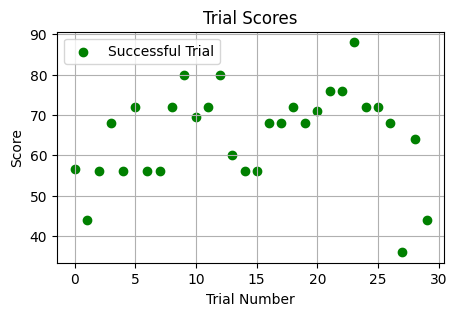

In [11]:
import matplotlib.pyplot as plt

trial_logs = compiled_program.trial_logs

# Extracting trial numbers, scores, and pruning status
trial_numbers = list(trial_logs.keys())
scores = [trial_logs[trial]['score'] for trial in trial_numbers]
pruning_status = [trial_logs[trial]['pruned'] for trial in trial_numbers]

# Plot setup
plt.figure(figsize=(5, 3))

# Plotting each point
for trial_number, score, pruned in zip(trial_numbers, scores, pruning_status):
    if pruned:
        plt.scatter(trial_number, score, color='grey', label='Pruned Trial' if 'Pruned Trial' not in plt.gca().get_legend_handles_labels()[1] else "")
    else:
        plt.scatter(trial_number, score, color='green', label='Successful Trial' if 'Successful Trial' not in plt.gca().get_legend_handles_labels()[1] else "")

plt.xlabel('Trial Number')
plt.ylabel('Score')
plt.title('Trial Scores')
plt.grid(True)
plt.legend()
plt.show()

We can also __visualize the best prompts__ discovered by MIPRO as our trials progress... (though note that score increases are also due to the selected fewshot examples, which are not shown here for conciseness).

In [12]:
best_score = 0

def get_signature(predictor):
    if (hasattr(predictor, 'extended_signature')):
        return predictor.extended_signature
    elif (hasattr(predictor, 'signature')):
        return predictor.signature

print(f"Baseline program | Score: {best_score}:")
for i,predictor in enumerate(program.predictors()):
    print(f"Prompt {i+1} Instruction: {get_signature(predictor).instructions}")
print()

print("----------------")

for trial_num in compiled_program.trial_logs:
    program_score = compiled_program.trial_logs[trial_num]["score"]
    program_pruned = compiled_program.trial_logs[trial_num]["pruned"]
    if program_score > best_score and not program_pruned and compiled_program.trial_logs[trial_num]["full_eval"]:
        best_score = program_score
        best_program_so_far = compiled_program.trial_logs[trial_num]["program"]
    if trial_num % 5 == 0:
        print(f"Best program after {trial_num} trials | Score: {best_score}:")
        for i,predictor in enumerate(best_program_so_far.predictors()):
            print(f"Prompt {i+1} Instruction: {get_signature(predictor).instructions}")
        print()

Baseline program | Score: 0:
Prompt 1 Instruction: context, question -> answer

----------------
Best program after 0 trials | Score: 56.5:
Prompt 1 Instruction: Provide a yes or no answer based on the given context and question. The context and question are used as input to generate the answer.

Best program after 5 trials | Score: 56.5:
Prompt 1 Instruction: Provide a yes or no answer based on the given context and question. The context and question are used as input to generate the answer.

Best program after 10 trials | Score: 69.5:
Prompt 1 Instruction: Given the context and question, generate a logical answer based on the reasoning process.

Best program after 15 trials | Score: 69.5:
Prompt 1 Instruction: Given the context and question, generate a logical answer based on the reasoning process.

Best program after 20 trials | Score: 71.0:
Prompt 1 Instruction: Determine if it can be logically concluded that a kayak is nearby based on the given context and question, and generate a

#### 3d] Saving your program for later use

Now that we've gone through all this work of compiling a program it would be a shame to throw it away.  Fortunately we don't have to.  We can save your compiled program to disk with .save()!

This file is also human interpretable, so it's worth taking a look at the optimized program.  You can load it later with .load() on a program with the same modules.

In [14]:
compiled_program.save("compiled_program.dspy")